# Partial Exam GLM

@roman avj

11 March 2024

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pymc as pm
import arviz as az


---
# Q1: Argentina Mortgage Data

Let $\theta$ be the rate of mortgage loans granted by a bank in Argentina. During 2023 the average rate was 60% and the standard deviation of the rate was 0.04. So far in 2024, 100 loans have been requested, of which only 50 have been granted.



## Q1.A: Beta Prior

Using the information from last year, find the beta distribution that best describes the initial knowledge


In [31]:
# solve system of equations
from scipy.optimize import fsolve

# define the system of equations
def equations(vars, b1, b2):
    # unpack
    alpha, beta = vars

    # define the equations as the mean and variance of a beta
    eq1 = alpha / (alpha + beta) - b1
    eq2 = (alpha * beta) / ((alpha + beta)**2 * (alpha + beta + 1)) - b2
    return [eq1, eq2]

# initial guess
init_guess = [1, 1]

# solve
alpha0, beta0 = fsolve(equations, init_guess, args=(0.6, 0.04**2))

# print
print(f"alpha: {alpha0:.2f}, beta: {beta0:.2f}")


alpha: 89.40, beta: 59.60


In [32]:
# check if the solution is correct
mean0 = alpha0 / (alpha0 + beta0)
variance0 = (alpha0 * beta0) / ((alpha0 + beta0)**2 * (alpha0 + beta0 + 1))
print(f"mean: {mean0:.2f}, std dev: {np.sqrt(variance0):.4f}")

mean: 0.60, std dev: 0.0400


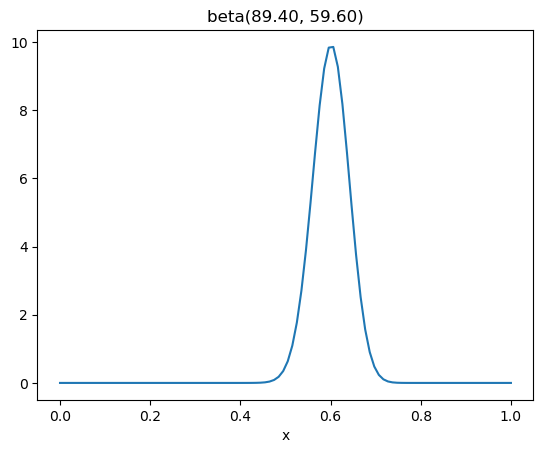

In [35]:
# plot the beta distribution
from scipy.stats import beta
x = np.linspace(0, 1, 100)
y = beta.pdf(x, float(alpha0), float(beta0))
plt.plot(x, y)
plt.title(f"beta({alpha0:.2f}, {beta0:.2f})")
plt.xlabel("x")
plt.show()

## Q1.B: Transformed Normal Distribution

Using the information from the previous year, find the transformed normal distribution that best describes the initial knowledge.


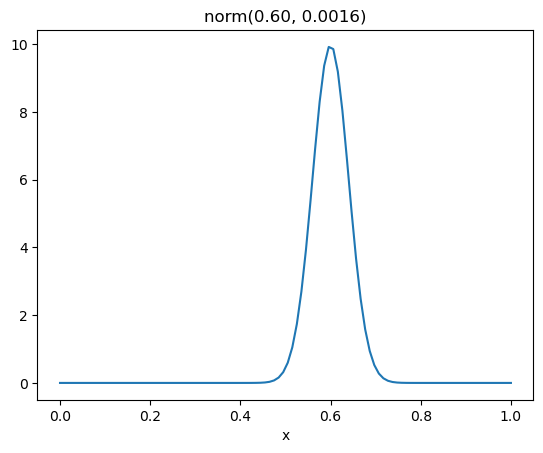

In [36]:
# we will suppose x ~ norm(0.6, 0.04**2)
from scipy.stats import norm

# params
mean0 = 0.6
variance0 = 0.04**2

# graph the normal distribution
x = np.linspace(0, 1, 100)
y = norm.pdf(x, loc=mean0, scale=np.sqrt(variance0))
plt.plot(x, y)
plt.title(f"norm({mean0:.2f}, {variance0:.4f})")
plt.xlabel("x")
plt.show()


## Q1.C: Initial Non-Informative Prior

Determine the inicial non-informative prior for the parameter $\theta$

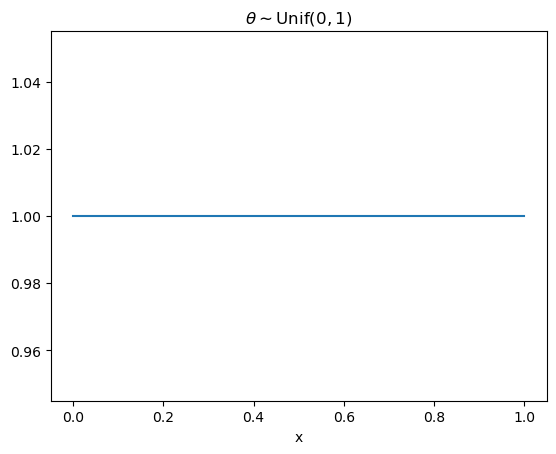

In [39]:
# we will assume \theta \propto 1 (but maybe is baised by jeffreys prior for beta distribution)
x = np.linspace(0, 1, 100)
y = np.repeat(1, 100)
plt.plot(x, y)
plt.title(r"$\theta \sim \text{Unif}(0,1)$")
plt.xlabel("x")
plt.show()

## Q1.D: Analytical Posterior distribution for 1.A, 1.B, 1.C

In [ ]:
# q1.d.a easy
# q1.d.b (wip)
# q1.d.c easy

## Q1.E: PyMC Posterior for 1.A, 1.B, 1.C

In [41]:
# 2005 params
n_obs = 100
n_success = 60

#### 1.A model

In [50]:
# posterior distribution for 1.a
with pm.Model() as model_1a:
    # prior
    theta = pm.Beta("theta", alpha=alpha0, beta=beta0)

    # likelihood
    y = pm.Binomial("y", n=n_obs, p=theta, observed=n_success)

    # sample
    prior_1a = pm.sample_prior_predictive(samples=1000, random_seed=42)
    trace_1a = pm.sample(2000, tune=1000, chains=4, random_seed=42, cores=4)
    posterior_1a = pm.sample_posterior_predictive(trace_1a, random_seed=42)

Sampling: [theta, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Sampling: [y]


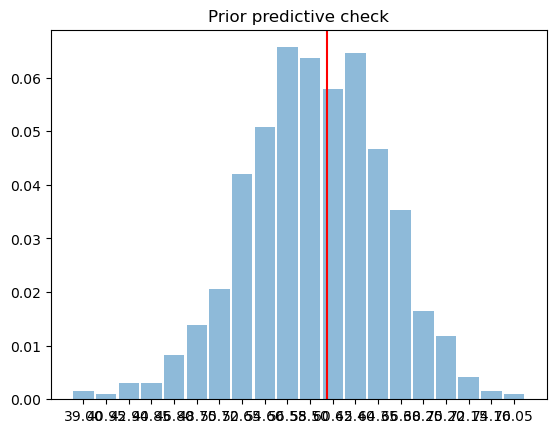

In [52]:
# prior predictive check
az.plot_dist(
    prior_1a.prior_predictive["y"],
    kind='hist',
    hist_kwargs={"bins": 20, "alpha": 0.5}
)

# add vline at observed 60
plt.axvline(60, color='red')
plt.title("Prior predictive check")
plt.show()

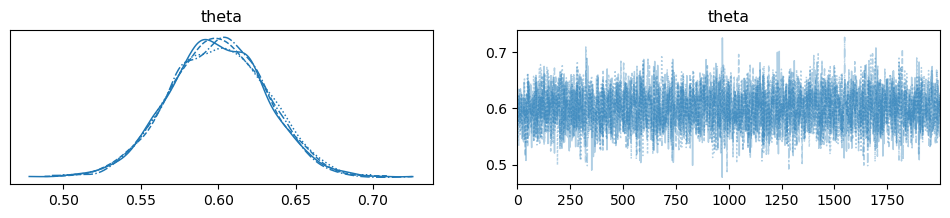

In [53]:
# posterior predictive check
az.plot_trace(trace_1a)
plt.show()

In [54]:
# summary of the trace
az.summary(trace_1a, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.6,0.031,0.55,0.652,0.001,0.0,3720.0,5128.0,1.0


<Axes: xlabel='y'>

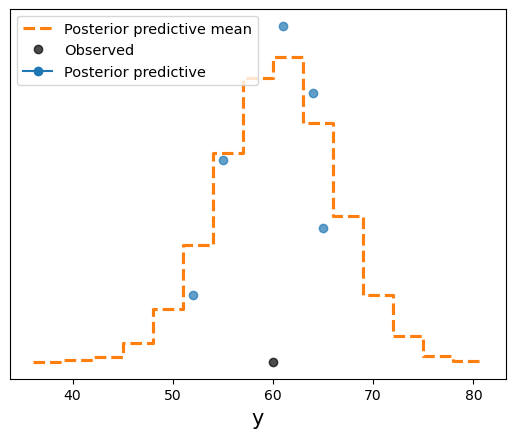

In [63]:
# posterior predictive
az.plot_ppc(
    posterior_1a,
    kind='scatter',
    data_pairs={"y": "y"}
)

### 1.B model

In [64]:
# posterior distribution for 1.a
with pm.Model() as model_1b:
    # prior
    theta = pm.Normal("theta", mu=mean0, sigma=np.sqrt(variance0))

    # likelihood
    y = pm.Binomial("y", n=n_obs, p=theta, observed=n_success)

    # sample
    prior_1b = pm.sample_prior_predictive(samples=1000, random_seed=42)
    trace_1b = pm.sample(2000, tune=1000, chains=4, random_seed=42, cores=4)
    posterior_1b = pm.sample_posterior_predictive(trace_1b, random_seed=42)

Sampling: [theta, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Sampling: [y]


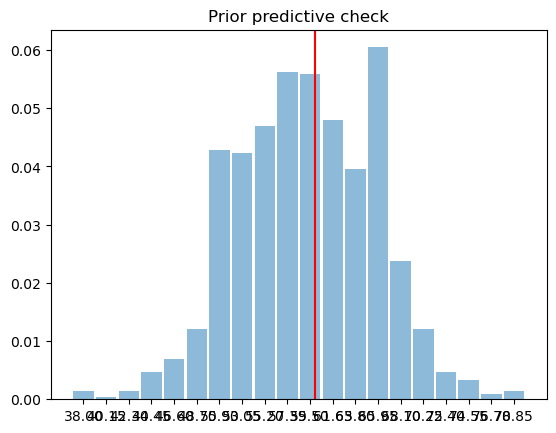

In [65]:
# prior predictive check
az.plot_dist(
    prior_1b.prior_predictive["y"],
    kind='hist',
    hist_kwargs={"bins": 20, "alpha": 0.5}
)

# add vline at observed 60
plt.axvline(60, color='red')
plt.title("Prior predictive check")
plt.show()

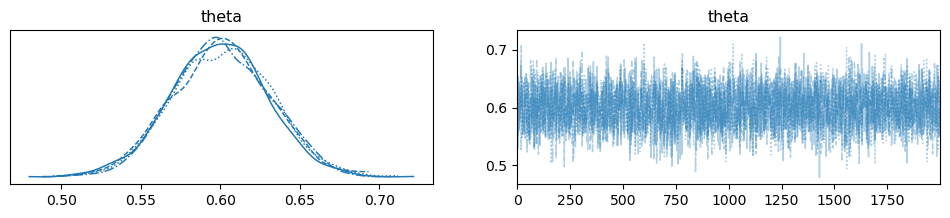

In [66]:
# posterior predictive check
az.plot_trace(trace_1b)
plt.show()

In [67]:
# summary of the trace
az.summary(trace_1b, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.6,0.031,0.552,0.652,0.001,0.0,3583.0,5256.0,1.0


/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

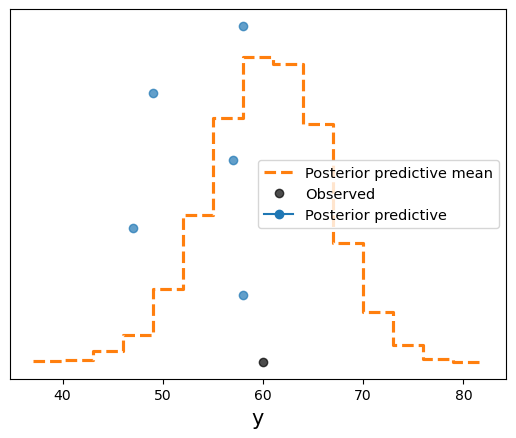

In [68]:
# posterior predictive
az.plot_ppc(
    posterior_1b,
    kind='scatter',
    data_pairs={"y": "y"}
)

### 1.C model

In [71]:
# posterior distribution for 1.a
with pm.Model() as model_1c:
    # prior
    theta = pm.Uniform("theta", lower=0, upper=1)

    # likelihood
    y = pm.Binomial("y", n=n_obs, p=theta, observed=n_success)

    # sample
    prior_1c = pm.sample_prior_predictive(samples=1000, random_seed=42)
    trace_1c = pm.sample(2000, tune=1000, chains=4, random_seed=42, cores=4)
    posterior_1c = pm.sample_posterior_predictive(trace_1c, random_seed=42)

Sampling: [theta, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Sampling: [y]


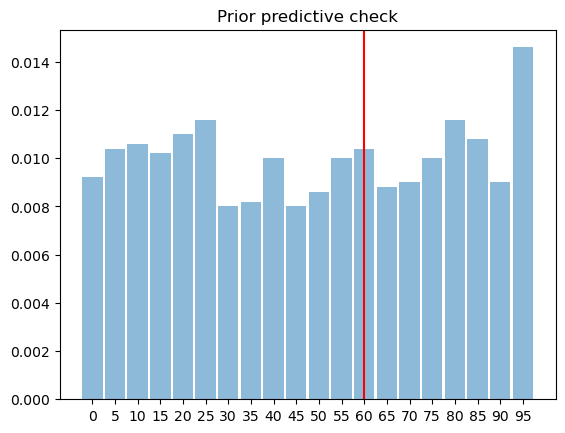

In [72]:
# prior predictive check
az.plot_dist(
    prior_1c.prior_predictive["y"],
    kind='hist',
    hist_kwargs={"bins": 20, "alpha": 0.5}
)

# add vline at observed 60
plt.axvline(60, color='red')
plt.title("Prior predictive check")
plt.show()

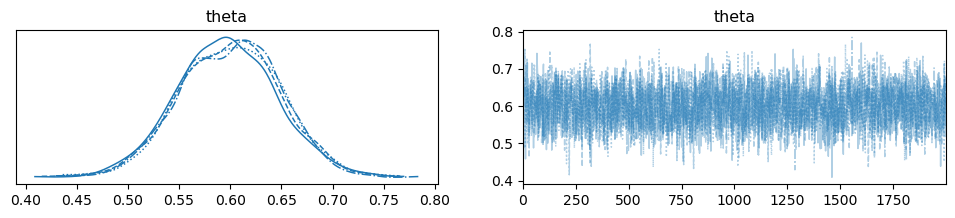

In [73]:
# posterior predictive check
az.plot_trace(trace_1c)
plt.show()

In [74]:
# summary of the trace
az.summary(trace_1c, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.599,0.049,0.523,0.681,0.001,0.001,3237.0,5215.0,1.0


/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

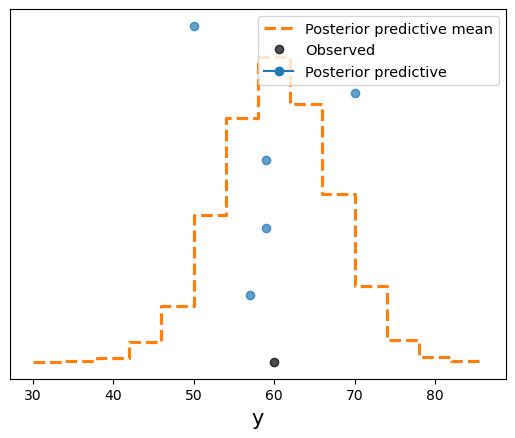

In [75]:
# posterior predictive
az.plot_ppc(
    posterior_1c,
    kind='scatter',
    data_pairs={"y": "y"}
)

## Q1.F

Estimate the odds of giving a credit, i.e. $\phi = \frac{\theta}{1-\theta}$, using the three different priors

In [76]:
# 2005 params
n_obs = 100
n_success = 60

#### 1.A model

In [77]:
# posterior distribution for 1.a
with pm.Model() as model_1a:
    # prior
    theta = pm.Beta("theta", alpha=alpha0, beta=beta0)
    phi = pm.Deterministic("phi", theta/(1-theta))

    # likelihood
    y = pm.Binomial("y", n=n_obs, p=theta, observed=n_success)

    # sample
    prior_1a = pm.sample_prior_predictive(samples=1000, random_seed=42)
    trace_1a = pm.sample(2000, tune=1000, chains=4, random_seed=42, cores=4)
    posterior_1a = pm.sample_posterior_predictive(trace_1a, random_seed=42)

Sampling: [theta, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Sampling: [y]


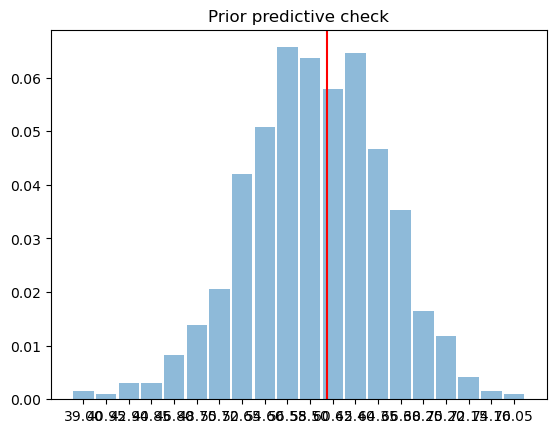

In [78]:
# prior predictive check
az.plot_dist(
    prior_1a.prior_predictive["y"],
    kind='hist',
    hist_kwargs={"bins": 20, "alpha": 0.5}
)

# add vline at observed 60
plt.axvline(60, color='red')
plt.title("Prior predictive check")
plt.show()

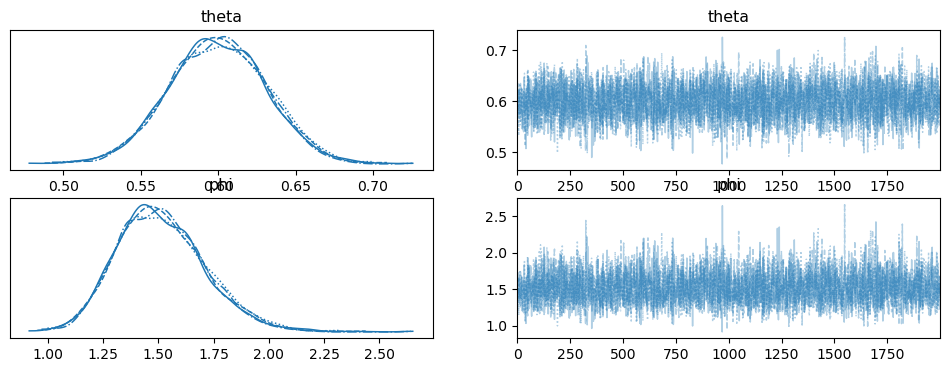

In [79]:
# posterior predictive check
az.plot_trace(trace_1a)
plt.show()

In [80]:
# summary of the trace
az.summary(trace_1a, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.600,0.031,0.550,0.652,0.001,0.000,3720.0,5128.0,1.0
phi,1.514,0.200,1.194,1.831,0.003,0.002,3720.0,5128.0,1.0


/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

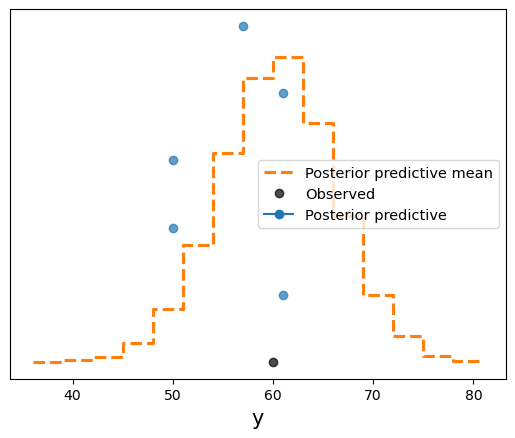

In [81]:
# posterior predictive
az.plot_ppc(
    posterior_1a,
    kind='scatter',
    data_pairs={"y": "y"}
)

### 1.B model

In [82]:
# posterior distribution for 1.a
with pm.Model() as model_1b:
    # prior
    theta = pm.Normal("theta", mu=mean0, sigma=np.sqrt(variance0))
    phi = pm.Deterministic("phi", theta/(1-theta))

    # likelihood
    y = pm.Binomial("y", n=n_obs, p=theta, observed=n_success)

    # sample
    prior_1b = pm.sample_prior_predictive(samples=1000, random_seed=42)
    trace_1b = pm.sample(2000, tune=1000, chains=4, random_seed=42, cores=4)
    posterior_1b = pm.sample_posterior_predictive(trace_1b, random_seed=42)

Sampling: [theta, y]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Sampling: [y]


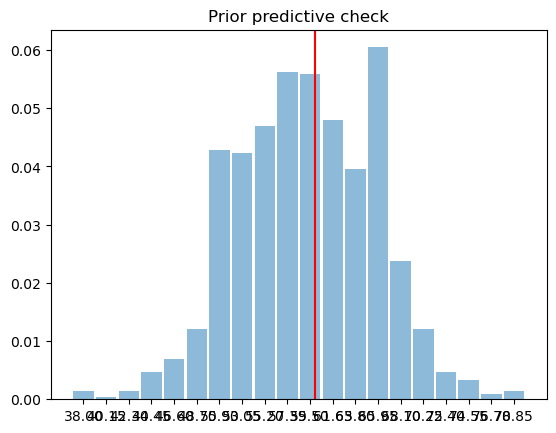

In [83]:
# prior predictive check
az.plot_dist(
    prior_1b.prior_predictive["y"],
    kind='hist',
    hist_kwargs={"bins": 20, "alpha": 0.5}
)

# add vline at observed 60
plt.axvline(60, color='red')
plt.title("Prior predictive check")
plt.show()

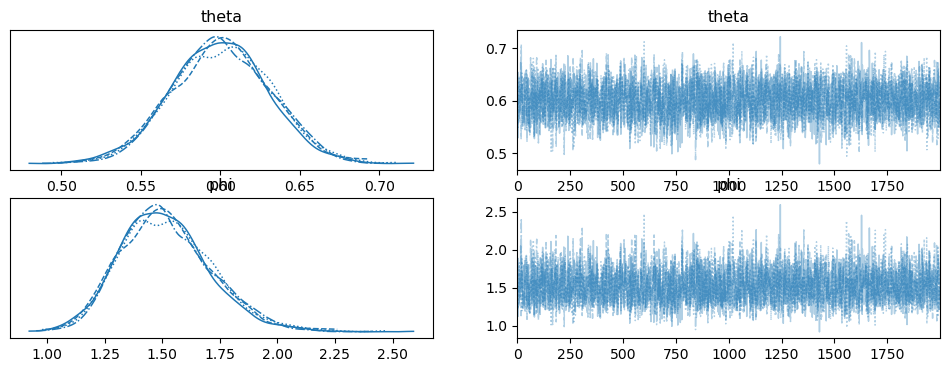

In [84]:
# posterior predictive check
az.plot_trace(trace_1b)
plt.show()

In [85]:
# summary of the trace
az.summary(trace_1b, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.600,0.031,0.552,0.652,0.001,0.000,3583.0,5256.0,1.0
phi,1.518,0.199,1.197,1.833,0.003,0.002,3583.0,5256.0,1.0


/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

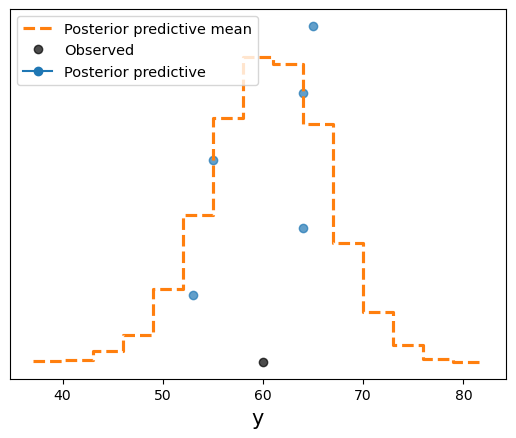

In [86]:
# posterior predictive
az.plot_ppc(
    posterior_1b,
    kind='scatter',
    data_pairs={"y": "y"}
)

### 1.C model

In [87]:
# posterior distribution for 1.a
with pm.Model() as model_1c:
    # prior
    theta = pm.Uniform("theta", lower=0, upper=1)
    phi = pm.Deterministic("phi", theta/(1-theta))

    # likelihood
    y = pm.Binomial("y", n=n_obs, p=theta, observed=n_success)

    # sample
    prior_1c = pm.sample_prior_predictive(samples=1000, random_seed=42)
    trace_1c = pm.sample(2000, tune=1000, chains=4, random_seed=42, cores=4)
    posterior_1c = pm.sample_posterior_predictive(trace_1c, random_seed=42)

Sampling: [theta, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Sampling: [y]


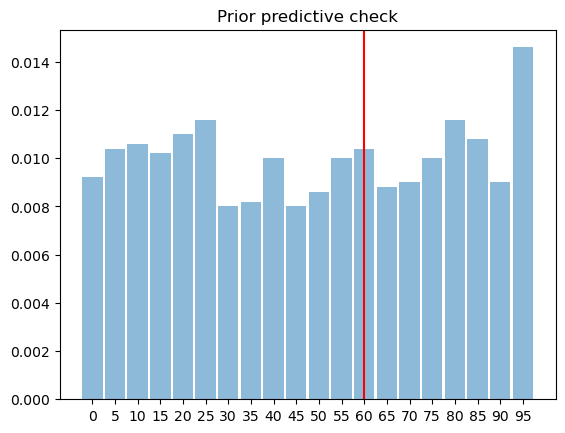

In [88]:
# prior predictive check
az.plot_dist(
    prior_1c.prior_predictive["y"],
    kind='hist',
    hist_kwargs={"bins": 20, "alpha": 0.5}
)

# add vline at observed 60
plt.axvline(60, color='red')
plt.title("Prior predictive check")
plt.show()

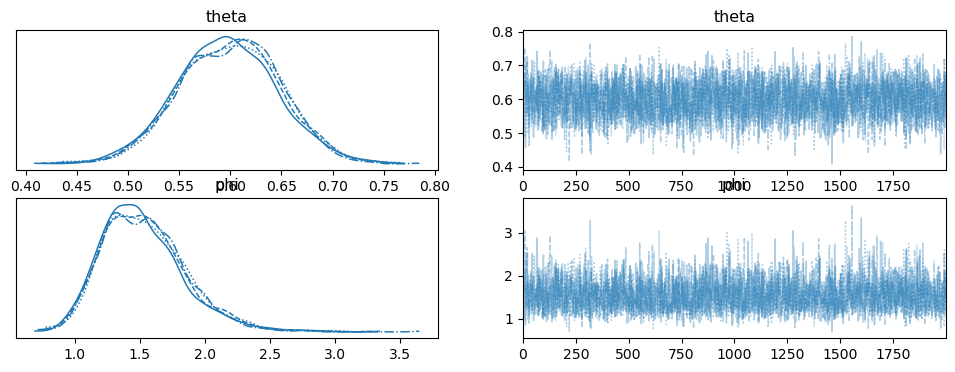

In [89]:
# posterior predictive check
az.plot_trace(trace_1c)
plt.show()

In [90]:
# summary of the trace
az.summary(trace_1c, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.599,0.049,0.523,0.681,0.001,0.001,3237.0,5215.0,1.0
phi,1.531,0.321,1.010,2.001,0.006,0.004,3237.0,5215.0,1.0


/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

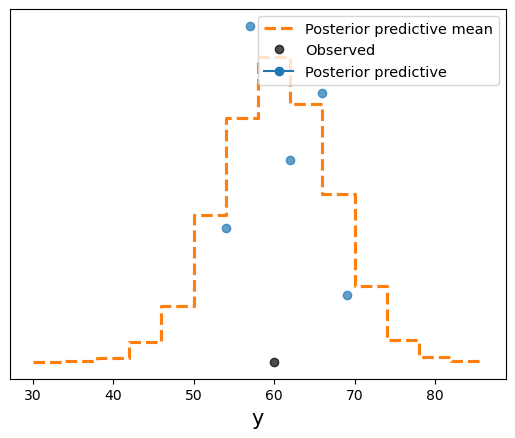

In [91]:
# posterior predictive
az.plot_ppc(
    posterior_1c,
    kind='scatter',
    data_pairs={"y": "y"}
)

# Sandbox